# 3. Data visualization
To get an insight in the structure of the Kaggle dataset, I tried to visualize it. 

In the end, we want to get a classifier that can take in a description and determines in which category this description belongs. Therefore, we import the data again and extract the category column. Because this is the column that holds our labels, we want to know in what numbers these are represented.

In [2]:
import pandas as pd

df = pd.read_csv('../darkweb/data/agora.csv')

categories = df[' Category']
categories_main = df[' Category'].apply(lambda x: x.split('/')[0])
descriptions = df[' Item'] + " " + df[' Item Description']

## Creating a cleaned DataFrame
The categories and descriptions are stored togeter into a new DataFrame, together with a category_id column that will help us count. Empty descriptions are deleted and categories that appear only once are deleted as well. I do this because there were a few categories that were clearly not a category. For example; a bitcoin price.

In [3]:
from io import StringIO

df = pd.DataFrame({'Category': categories, 'Item Description': descriptions})
df = df[pd.notnull(df['Item Description'])] # no empty descriptions
df = df[df.groupby('Category')['Category'].transform(len) > 1] # only categories that appear more than once

df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head()

,Category,Item Description,category_id
0,Services/Hacking,12 Month HuluPlus gift Code 12-Month HuluPlus ...,0
1,Services/Hacking,Pay TV Sky UK Sky Germany HD TV and much mor...,0
2,Services/Hacking,OFFICIAL Account Creator Extreme 4.2 Tagged Su...,0
3,Services/Hacking,VPN > TOR > SOCK TUTORIAL How to setup a VPN >...,0
4,Services/Hacking,Facebook hacking guide . This guide will teac...,0


## Plotting
Now that we have our dataframe, we can plot the data and visualize it. As you can see, there are quite a lot of (sub) categories. The drugs categories are by far the most represented.

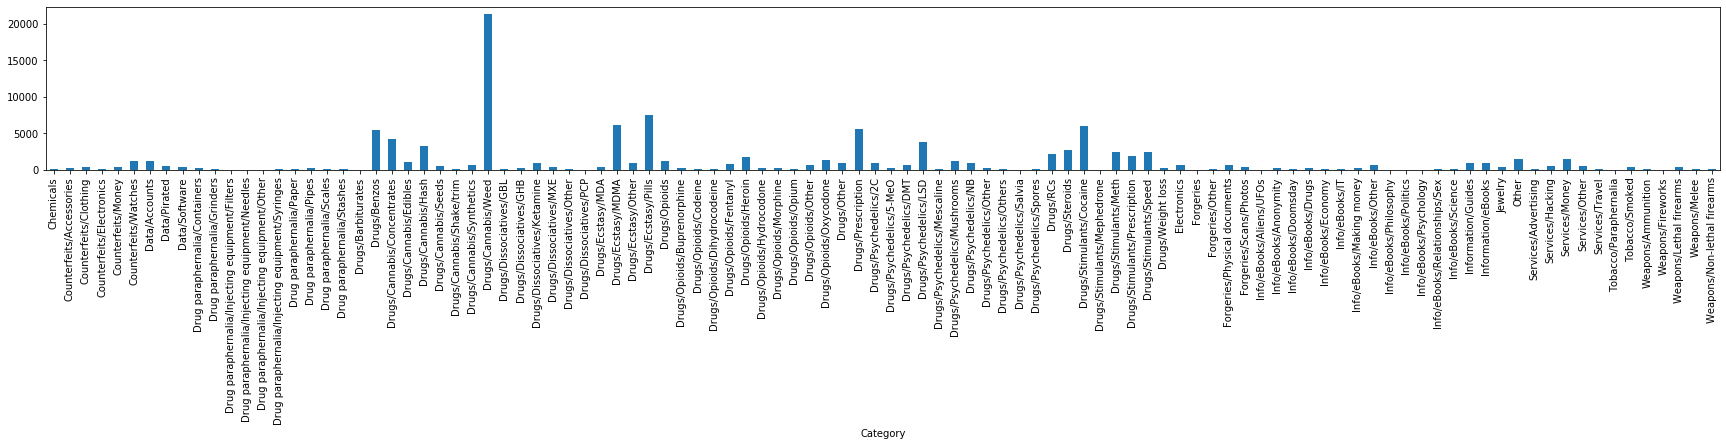

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,3))
df.groupby('Category')['Item Description'].count().plot.bar(ylim=0)
plt.show()

## Main categories
Because there are a lot of categories, let's try and take only the main ones, and discard all the sub divisions. Now, the seperation is much more clear.

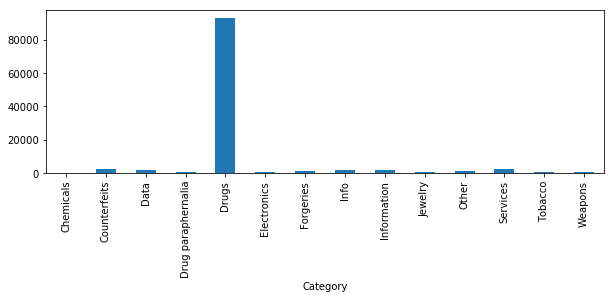

In [13]:
df = pd.DataFrame({'Category': categories_main, 'Item Description': descriptions})
df = df[pd.notnull(df['Item Description'])] # no empty descriptions
df = df[df.groupby('Category')['Category'].transform(len) > 1] # only categories that appear more than once

df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

fig = plt.figure(figsize=(10,3))
df.groupby('Category')['Item Description'].count().plot.bar(ylim=0)
plt.show()

## Unigrams and bigrams
To get further insight into the data, I found a way to display what words and word pairs occur most in each category. To do this, the data is first transformed into TFIDF vectors. 

As you can see, most of the uni- and bigrams look quite logical. This probably means that there won't be really weird results when put into a ML algorithm.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(df['Item Description'])
labels = df.category_id

N = 2
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Chemicals':
  . Most correlated unigrams:
. camphor
. phosphorus
  . Most correlated bigrams:
. selected with
. orders selected
# 'Counterfeits':
  . Most correlated unigrams:
. replica
. material
  . Most correlated bigrams:
. steel case
. stainless steel
# 'Data':
  . Most correlated unigrams:
. account
. lifetime
  . Most correlated bigrams:
. account lifetime
. lifetime freebies
# 'Drug paraphernalia':
  . Most correlated unigrams:
. stash
. grinder
  . Most correlated bigrams:
. have you
. you ever
# 'Drugs':
  . Most correlated unigrams:
. replica
. account
  . Most correlated bigrams:
. stainless steel
. how to
# 'Electronics':
  . Most correlated unigrams:
. activated
. sim
  . Most correlated bigrams:
. sim cards
. off retail
# 'Forgeries':
  . Most correlated unigrams:
. scan
. passport
  . Most correlated bigrams:
. passport scan
. fake id
# 'Info':
  . Most correlated unigrams:
. pdf
. guide
  . Most correlated bigrams:
. format pdf
. for dummies
# 'Information':
  . Mos